Milestone 2 | June 2023 | Group 15

### This script utilizes the pycaret library to run various ML models using our datasets
- sl_base_dataset
- sl_derived_dataset

In [3]:
# 20230622_0148 EST
# Updates: now using Pycaret with normalize=True in setup() function.
# More descriptions / section headers / reduced code length in some cells / ran pycaret 4 times.  
# 2023_06_26 Update
# - Modified filepaths for compatibility with github repo
# - output file is saved to SIADS-MILESTONE-II/datasets/SL_outputs

In [4]:
import pycaret
import pandas as pd
import numpy as np
from pycaret.classification import *

In [5]:
def pycaret_setup_and_model_table(df, target_var):
    s = setup(df, target = TARGET_VAR, session_id = 1, normalize=True)
    best = compare_models()
    return best

In [6]:
def add_columns(df, cols_to_add, df_s2d):
    df = df.copy()
    for i in range(len(cols_to_add)):
        df[cols_to_add[i]] = df_s2d[cols_to_add[i]]

    df.insert(len(df.columns) - 1, 'FTR', df.pop('FTR'))
    return df

#### Global Variable: TARGET_VAR
    - This variable points to FTR, the dataset feature we want to predict.  
    - Note that Pycaret maps the FTR values like so: A: 0, D: 1, H: 2.

In [7]:
TARGET_VAR = 'FTR'

#### Open and Explore the _Base dataset_:

In [8]:
base_df = pd.read_csv("..\datasets\SL_outputs\sl_base_dataset_2023_06.csv")
print(base_df.shape)
base_df.head(2)

(8020, 22)


,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1,2000-08-19,Charlton,Man City,4,0,H,2,0,H,...,14,4,13,12,6,6,1,2,0,0
1,1,2000-08-19,Chelsea,West Ham,4,2,H,1,0,H,...,10,5,19,14,7,7,1,2,0,0


In [9]:
base_df.describe()

,season,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000,8020.000000
mean,11.167082,1.516958,1.156234,0.680798,0.506983,13.502244,10.638529,6.166085,4.807232,11.416085,11.919950,6.097756,4.788030,1.413716,1.749252,0.063840,0.090399
std,6.263094,1.297628,1.142172,0.829591,0.723418,5.249184,4.576750,3.334059,2.803895,3.789224,3.967423,3.094782,2.722564,1.189140,1.267882,0.255459,0.298698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,0.000000,0.000000,0.000000,10.000000,7.000000,4.000000,3.000000,9.000000,9.000000,4.000000,3.000000,0.000000,1.000000,0.000000,0.000000
50%,11.000000,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,6.000000,4.000000,11.000000,12.000000,6.000000,4.000000,1.000000,2.000000,0.000000,0.000000
75%,16.000000,2.000000,2.000000,1.000000,1.000000,17.000000,13.000000,8.000000,6.000000,14.000000,14.000000,8.000000,6.000000,2.000000,3.000000,0.000000,0.000000
max,22.000000,9.000000,9.000000,5.000000,5.000000,43.000000,31.000000,24.000000,20.000000,33.000000,29.000000,20.000000,19.000000,7.000000,9.000000,3.000000,2.000000


# ============================================================

# 1. Running pycaret with the base dataset (all 22 seasons.  2000-2022)
- In this iteration, we test how well we can predict the FTR using in-game data while avoiding data leakage.

- Columns excluded from models: full match score, halftime results
    - Why exclude Full match score: (FTHG (_full time home goals_), FTAG (_full time away goals_)) will cause data leakage because they give away the result.
    - Why exclude halftime results: (HTHG, HTAG, and HTR) half-time results are sometimes the same as the full time result.


In [10]:
print('Column count: ', len(base_df.columns))
base_df.columns

Column count:  22


Index(['season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY',
       'AY', 'HR', 'AR'],
      dtype='object')

#### 1a. Trim the base dataset to Remove columns that will or may cause data leakage: 

In [11]:
working_df = base_df.copy()
# keep target column as the last column
working_df.insert(len(working_df.columns) - 1, 'FTR', working_df.pop('FTR'))

# TRIM base_df: remove data leakage and unnecessary features such as season, date, Hometeam name, awayteam name
exclude_cols = ['season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR']
df_cols = [colname for colname in working_df.columns if colname not in (exclude_cols)]

working_df = working_df[df_cols]
print(working_df.shape)
working_df.head(3)

(8020, 13)


,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
0,17,8,14,4,13,12,6,6,1,2,0,0,H
1,17,12,10,5,19,14,7,7,1,2,0,0,H
2,6,16,3,9,15,21,8,4,5,3,1,0,A


#### 1b. Run Pycaret with base dataset DF:

In [12]:
best = pycaret_setup_and_model_table(working_df, TARGET_VAR)

,Description,Value
0,Session id,1
1,Target,FTR
2,Target type,Multiclass
3,Target mapping,"A: 0, D: 1, H: 2"
4,Original data shape,"(8020, 13)"
5,Transformed data shape,"(8020, 13)"
6,Transformed train set shape,"(5614, 13)"
7,Transformed test set shape,"(2406, 13)"
8,Numeric features,12
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5661,0.7204,0.5661,0.5144,0.4995,0.2800,0.3052,1.3440
lda,Linear Discriminant Analysis,0.5650,0.7197,0.5650,0.5173,0.5085,0.2808,0.3019,0.9330
ridge,Ridge Classifier,0.5631,0.0000,0.5631,0.5008,0.4836,0.2695,0.3005,0.9220
gbc,Gradient Boosting Classifier,0.5623,0.7208,0.5623,0.5187,0.5162,0.2818,0.2977,0.9360
ada,Ada Boost Classifier,0.5574,0.7018,0.5574,0.5194,0.5078,0.2724,0.2899,0.9300
svm,SVM - Linear Kernel,0.5517,0.0000,0.5517,0.5079,0.4900,0.2564,0.2792,0.9220
et,Extra Trees Classifier,0.5515,0.6969,0.5515,0.5135,0.5134,0.2666,0.2788,0.9920
rf,Random Forest Classifier,0.5511,0.6964,0.5511,0.5150,0.5158,0.2680,0.2790,1.0380
qda,Quadratic Discriminant Analysis,0.5497,0.6934,0.5497,0.4899,0.4863,0.2491,0.2727,0.9340
lightgbm,Light Gradient Boosting Machine,0.5417,0.7007,0.5417,0.5074,0.5128,0.2576,0.2652,1.0130


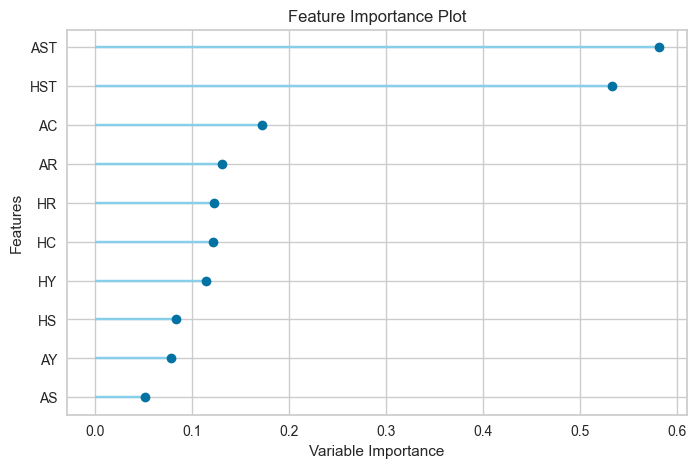

In [13]:
plot_model(best, plot = 'feature')

# ============================================================

# 2.  Running pycaret with SEASON-TO-DATE (S2D) derived dataset 

#### 2a. Open and prepare the derived dataset

In [15]:
df_s2d = pd.read_csv("..\datasets\SL_outputs\sl_derived_dataset_2023_06.csv")
print(df_s2d.shape)
df_s2d.head(2)

# Note: it is normal to see NaN values at the start of each season

(8020, 125)


,date,season,home_team,away_team,FTR,H_home_goals_s2d,H_away_goals_s2d,H_total_goals_s2d,H_avg_home_goals_s2d,H_avg_away_goals_s2d,...,A_total_points_s2d,A_avg_home_points_s2d,A_avg_away_points_s2d,A_avg_points_s2d,A_home_points_against_s2d,A_away_points_against_s2d,A_total_points_against_s2d,A_avg_home_points_against_s2d,A_avg_away_points_against_s2d,A_avg_points_against_s2d
0,2000-08-19,1,Charlton,Man City,H,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-08-19,1,Chelsea,West Ham,H,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Once again, trim DF to remove team names, date, season number
df_s2d_for_model = df_s2d.iloc[:,4:]
df_s2d_for_model.sample(4)

,FTR,H_home_goals_s2d,H_away_goals_s2d,H_total_goals_s2d,H_avg_home_goals_s2d,H_avg_away_goals_s2d,H_avg_goals_s2d,H_home_goals_against_s2d,H_away_goals_against_s2d,H_total_goals_against_s2d,...,A_total_points_s2d,A_avg_home_points_s2d,A_avg_away_points_s2d,A_avg_points_s2d,A_home_points_against_s2d,A_away_points_against_s2d,A_total_points_against_s2d,A_avg_home_points_against_s2d,A_avg_away_points_against_s2d,A_avg_points_against_s2d
5629,D,11.0,9.0,20.0,0.733333,0.562500,0.645161,19.0,23.0,42.0,...,25.0,1.187500,0.400000,0.806452,25.0,39.0,64.0,1.562500,2.600000,2.064516
3789,A,41.0,31.0,72.0,2.277778,1.722222,2.000000,19.0,24.0,43.0,...,67.0,2.315789,1.352941,1.861111,11.0,23.0,34.0,0.578947,1.352941,0.944444
1692,A,12.0,14.0,26.0,1.500000,1.555556,1.529412,8.0,17.0,25.0,...,20.0,1.333333,1.000000,1.176471,12.0,14.0,26.0,1.333333,1.750000,1.529412
6154,D,9.0,9.0,18.0,3.000000,2.250000,2.571429,2.0,5.0,7.0,...,14.0,2.000000,2.000000,2.000000,2.0,3.0,5.0,0.500000,1.000000,0.714286


#### Derived Column names printed below for reference
#### _Naming Convention_: 
    - Features beginning with "H_" denote that the feature belongs to the hometeam
    - Likewise features beginning with "A_" denote that the feature belongs to the hometeam

In [17]:
print('Column count: ', len(df_s2d_for_model.columns))
df_s2d_for_model.columns

Column count:  121


Index(['FTR', 'H_home_goals_s2d', 'H_away_goals_s2d', 'H_total_goals_s2d',
       'H_avg_home_goals_s2d', 'H_avg_away_goals_s2d', 'H_avg_goals_s2d',
       'H_home_goals_against_s2d', 'H_away_goals_against_s2d',
       'H_total_goals_against_s2d',
       ...
       'A_total_points_s2d', 'A_avg_home_points_s2d', 'A_avg_away_points_s2d',
       'A_avg_points_s2d', 'A_home_points_against_s2d',
       'A_away_points_against_s2d', 'A_total_points_against_s2d',
       'A_avg_home_points_against_s2d', 'A_avg_away_points_against_s2d',
       'A_avg_points_against_s2d'],
      dtype='object', length=121)

#### 2b. Keep only those columns with the highest impact for prediction
note: will do a more formal process of selecting the columns for the final report - Erick 6/21/23 23:40

In [18]:
# # These are the columns we want to copy from S2D dataframe to the working dataframe.
# # Reasoning: avg s2d values seem to improve the models' accuracy

s2d_cols =   [ 'FTR',
'H_avg_home_goals_s2d', 'H_avg_away_goals_s2d', 'H_avg_goals_s2d',
'A_avg_home_goals_s2d', 'A_avg_away_goals_s2d', 'A_avg_goals_s2d', 

'H_avg_home_goals_against_s2d', 'H_avg_away_goals_against_s2d', 'H_avg_goals_against_s2d', 
'A_avg_home_goals_against_s2d', 'A_avg_away_goals_against_s2d', 'A_avg_goals_against_s2d',

'H_avg_home_shots_on_target_s2d', 'H_avg_away_shots_on_target_s2d', 'H_avg_shots_on_target_s2d',
'A_avg_home_shots_on_target_s2d', 'A_avg_away_shots_on_target_s2d', 'A_avg_shots_on_target_s2d',

'H_avg_home_shots_on_target_against_s2d', 'H_avg_away_shots_on_target_against_s2d', 'H_avg_shots_on_target_against_s2d',
'A_avg_home_shots_on_target_against_s2d', 'A_avg_away_shots_on_target_against_s2d', 'A_avg_shots_on_target_against_s2d',

'H_avg_home_corners_s2d','H_avg_away_corners_s2d', 'H_avg_corners_s2d',
'A_avg_home_corners_s2d', 'A_avg_away_corners_s2d', 'A_avg_corners_s2d',

'H_avg_home_corners_against_s2d', 'H_avg_away_corners_against_s2d', 'H_avg_corners_against_s2d',
'A_avg_home_corners_against_s2d', 'A_avg_away_corners_against_s2d', 'A_avg_corners_against_s2d',

'H_avg_home_points_s2d','H_avg_away_points_s2d','H_avg_points_s2d',
'H_avg_home_points_against_s2d','H_avg_away_points_against_s2d','H_avg_points_against_s2d',

'A_avg_home_points_s2d','A_avg_away_points_s2d','A_avg_points_s2d',
'A_avg_home_points_against_s2d','A_avg_away_points_against_s2d','A_avg_points_against_s2d'
]

print('Count of Columns kept:', len(s2d_cols))

Count of Columns kept: 49


In [19]:
d2 = df_s2d_for_model[s2d_cols]
d2.sample(3)

,FTR,H_avg_home_goals_s2d,H_avg_away_goals_s2d,H_avg_goals_s2d,A_avg_home_goals_s2d,A_avg_away_goals_s2d,A_avg_goals_s2d,H_avg_home_goals_against_s2d,H_avg_away_goals_against_s2d,H_avg_goals_against_s2d,...,H_avg_points_s2d,H_avg_home_points_against_s2d,H_avg_away_points_against_s2d,H_avg_points_against_s2d,A_avg_home_points_s2d,A_avg_away_points_s2d,A_avg_points_s2d,A_avg_home_points_against_s2d,A_avg_away_points_against_s2d,A_avg_points_against_s2d
541,H,1.000000,1.000000,1.000000,1.111111,0.428571,0.812500,2.000000,1.333333,1.600000,...,0.866667,2.166667,2.000000,2.066667,1.666667,0.714286,1.250000,1.000000,2.00,1.437500
5816,D,2.000000,2.000000,2.000000,2.000000,1.400000,1.727273,1.800000,1.000000,1.363636,...,1.818182,1.400000,0.666667,1.000000,1.333333,1.600000,1.454545,1.333333,1.00,1.181818
5657,H,1.133333,0.777778,0.939394,1.588235,1.250000,1.424242,1.333333,1.388889,1.363636,...,0.939394,1.666667,1.833333,1.757576,1.882353,1.625000,1.757576,0.823529,1.25,1.030303


#### 2c. Run pycaret with the filtered dataset above.
#### Model results using only _Season to date_ dataset:

In [20]:
#run pycaret model table
best = pycaret_setup_and_model_table(d2, TARGET_VAR)

,Description,Value
0,Session id,1
1,Target,FTR
2,Target type,Multiclass
3,Target mapping,"A: 0, D: 1, H: 2"
4,Original data shape,"(8020, 49)"
5,Transformed data shape,"(8020, 49)"
6,Transformed train set shape,"(5614, 49)"
7,Transformed test set shape,"(2406, 49)"
8,Numeric features,48
9,Rows with missing values,11.3%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.5207,0.6570,0.5207,0.4606,0.4464,0.1879,0.2150,0.8690
ridge,Ridge Classifier,0.5196,0.0000,0.5196,0.4437,0.4387,0.1835,0.2128,0.9530
lr,Logistic Regression,0.5187,0.6575,0.5187,0.4546,0.4432,0.1847,0.2114,0.9770
et,Extra Trees Classifier,0.5143,0.6464,0.5143,0.4710,0.4553,0.1818,0.2032,0.9500
gbc,Gradient Boosting Classifier,0.5139,0.6475,0.5139,0.4525,0.4484,0.1788,0.2018,0.9670
rf,Random Forest Classifier,0.5109,0.6440,0.5109,0.4607,0.4553,0.1787,0.1976,0.9550
ada,Ada Boost Classifier,0.5011,0.6161,0.5011,0.4507,0.4340,0.1568,0.1779,0.9410
lightgbm,Light Gradient Boosting Machine,0.4979,0.6388,0.4979,0.4507,0.4521,0.1655,0.1782,0.9060
nb,Naive Bayes,0.4745,0.6568,0.4745,0.4864,0.4789,0.1941,0.1948,0.9460
svm,SVM - Linear Kernel,0.4740,0.0000,0.4740,0.4471,0.4381,0.1363,0.1455,0.9290


In [17]:
# plot_model(best, plot = 'confusion_matrix')

In [18]:
# plot_model(best, plot = 'auc')

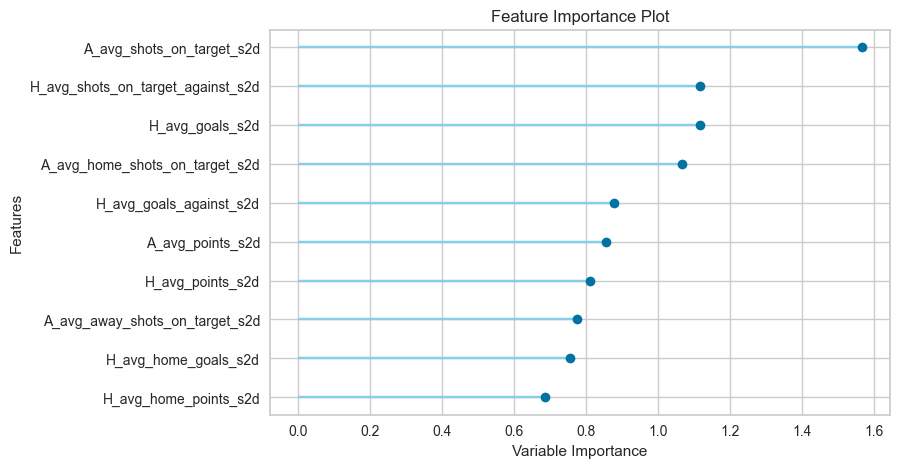

In [21]:
plot_model(best, plot = 'feature')

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

# Test 1: Mixed dataset

#### Running Pycaret with mix of base dataset AND derived dataset features 

Intent: predict match outcome using season to date metrics plus data from the match itself (except final score/result, and half time score/result) 

#### 1a. Prep the dataset

In [22]:
working_df2 = base_df.copy()
working_df2.insert(len(working_df2.columns) - 1, 'FTR', working_df2.pop('FTR'))
working_df2.sample(3)

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HTR,HS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
5629,15,2015-04-07,Aston Villa,QPR,3,3,2,1,H,21,...,5,8,12,7,3,0,4,0,0,D
3789,10,2010-05-05,Man City,Tottenham,0,1,0,0,D,10,...,6,12,14,9,7,0,3,0,0,A
1692,5,2004-12-18,Bolton,Man City,0,1,0,0,D,14,...,2,17,12,8,1,0,0,0,0,A


In [23]:
# Drop non-relevant or leakage-prone features. 
exclude_cols = ['season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR']

df_cols = [colname for colname in working_df2.columns if colname not in (exclude_cols)]
working_df2 = working_df2[df_cols]
print(working_df2.shape)
working_df2.head(2)

(8020, 13)


,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
0,17,8,14,4,13,12,6,6,1,2,0,0,H
1,17,12,10,5,19,14,7,7,1,2,0,0,H


#### 1b. Add avg columns from S2D df

In [24]:
working_df2 = add_columns(working_df2, s2d_cols, df_s2d)
working_df2.sample(2)

,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,...,H_avg_home_points_against_s2d,H_avg_away_points_against_s2d,H_avg_points_against_s2d,A_avg_home_points_s2d,A_avg_away_points_s2d,A_avg_points_s2d,A_avg_home_points_against_s2d,A_avg_away_points_against_s2d,A_avg_points_against_s2d,FTR
541,14,5,5,3,11,13,3,1,1,2,...,2.166667,2.000000,2.066667,1.666667,0.714286,1.250000,1.000000,2.0,1.437500,H
5816,16,13,5,4,11,12,3,5,1,2,...,1.400000,0.666667,1.000000,1.333333,1.600000,1.454545,1.333333,1.0,1.181818,D


In [25]:
print('Column count: ', len(working_df2.columns))
working_df2.columns

Column count:  61


Index(['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR',
       'AR', 'H_avg_home_goals_s2d', 'H_avg_away_goals_s2d', 'H_avg_goals_s2d',
       'A_avg_home_goals_s2d', 'A_avg_away_goals_s2d', 'A_avg_goals_s2d',
       'H_avg_home_goals_against_s2d', 'H_avg_away_goals_against_s2d',
       'H_avg_goals_against_s2d', 'A_avg_home_goals_against_s2d',
       'A_avg_away_goals_against_s2d', 'A_avg_goals_against_s2d',
       'H_avg_home_shots_on_target_s2d', 'H_avg_away_shots_on_target_s2d',
       'H_avg_shots_on_target_s2d', 'A_avg_home_shots_on_target_s2d',
       'A_avg_away_shots_on_target_s2d', 'A_avg_shots_on_target_s2d',
       'H_avg_home_shots_on_target_against_s2d',
       'H_avg_away_shots_on_target_against_s2d',
       'H_avg_shots_on_target_against_s2d',
       'A_avg_home_shots_on_target_against_s2d',
       'A_avg_away_shots_on_target_against_s2d',
       'A_avg_shots_on_target_against_s2d', 'H_avg_home_corners_s2d',
       'H_avg_away_corners_s2d', 'H_avg_cor

#### 2.Run pycaret with resulting dataset above.

In [26]:
best = pycaret_setup_and_model_table(working_df2, TARGET_VAR)

,Description,Value
0,Session id,1
1,Target,FTR
2,Target type,Multiclass
3,Target mapping,"A: 0, D: 1, H: 2"
4,Original data shape,"(8020, 61)"
5,Transformed data shape,"(8020, 61)"
6,Transformed train set shape,"(5614, 61)"
7,Transformed test set shape,"(2406, 61)"
8,Numeric features,60
9,Rows with missing values,11.3%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5812,0.7409,0.5812,0.5454,0.5412,0.3150,0.3301,1.0580
ridge,Ridge Classifier,0.5807,0.0000,0.5807,0.5274,0.5152,0.3065,0.3323,0.8430
lr,Logistic Regression,0.5789,0.7425,0.5789,0.5369,0.5345,0.3118,0.3275,0.9390
lda,Linear Discriminant Analysis,0.5778,0.7422,0.5778,0.5399,0.5405,0.3128,0.3254,0.9310
lightgbm,Light Gradient Boosting Machine,0.5677,0.7288,0.5677,0.5318,0.5375,0.3001,0.3089,0.9420
ada,Ada Boost Classifier,0.5666,0.7104,0.5666,0.5281,0.5221,0.2924,0.3074,0.9610
rf,Random Forest Classifier,0.5515,0.7015,0.5515,0.5082,0.5041,0.2601,0.2769,0.8930
et,Extra Trees Classifier,0.5515,0.7007,0.5515,0.4999,0.4972,0.2560,0.2759,1.0760
svm,SVM - Linear Kernel,0.5315,0.0000,0.5315,0.4992,0.5035,0.2495,0.2564,0.8350
nb,Naive Bayes,0.5118,0.6841,0.5118,0.5114,0.5105,0.2433,0.2438,0.8370


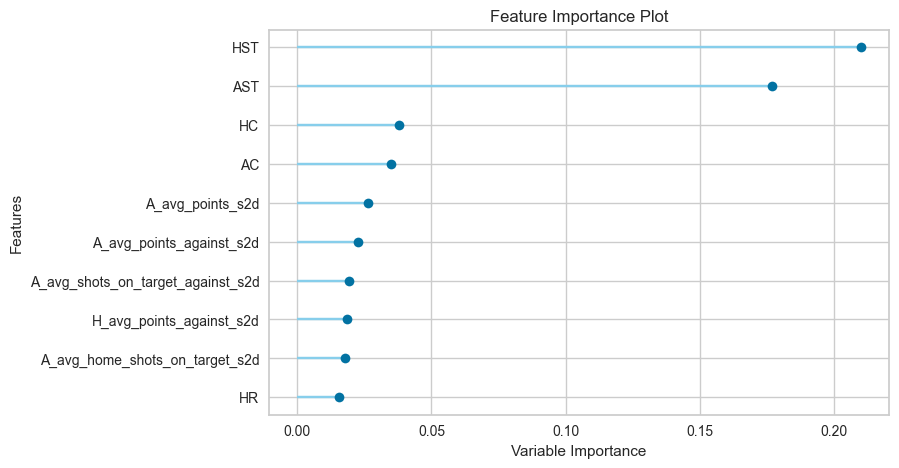

In [27]:
plot_model(best, plot = 'feature')

# = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =

# Test 2: Last-Mile prediction. 
### Running Pycaret with mix of base dataset AND derived S2D features.  In this iteration, we are including the halftime goal columns (HTHG, and HTAG) from the base dataset.

Intent: predict match outcome using season to date metrics plus data from the match itself (all except final score/result) 

#### 1a. Prep the dataset

In [28]:
working_df2 = base_df.copy()
working_df2.insert(len(working_df2.columns) - 1, 'FTR', working_df2.pop('FTR'))
working_df2.sample(3)

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HTR,HS,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
5629,15,2015-04-07,Aston Villa,QPR,3,3,2,1,H,21,...,5,8,12,7,3,0,4,0,0,D
3789,10,2010-05-05,Man City,Tottenham,0,1,0,0,D,10,...,6,12,14,9,7,0,3,0,0,A
1692,5,2004-12-18,Bolton,Man City,0,1,0,0,D,14,...,2,17,12,8,1,0,0,0,0,A


In [29]:
# Drop non-relevant or leakage-prone features. 
# exclude_cols = ['season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR']
exclude_cols = ['season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTR']

df_cols = [colname for colname in working_df2.columns if colname not in (exclude_cols)]
working_df2 = working_df2[df_cols]
print(working_df2.shape)
working_df2.head(2)

(8020, 15)


,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,FTR
0,2,0,17,8,14,4,13,12,6,6,1,2,0,0,H
1,1,0,17,12,10,5,19,14,7,7,1,2,0,0,H


#### 1b. Add avg columns from S2D df

In [30]:
working_df2 = add_columns(working_df2, s2d_cols, df_s2d)
working_df2.sample(2)

,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,...,H_avg_home_points_against_s2d,H_avg_away_points_against_s2d,H_avg_points_against_s2d,A_avg_home_points_s2d,A_avg_away_points_s2d,A_avg_points_s2d,A_avg_home_points_against_s2d,A_avg_away_points_against_s2d,A_avg_points_against_s2d,FTR
541,1,0,14,5,5,3,11,13,3,1,...,2.166667,2.000000,2.066667,1.666667,0.714286,1.250000,1.000000,2.0,1.437500,H
5816,1,1,16,13,5,4,11,12,3,5,...,1.400000,0.666667,1.000000,1.333333,1.600000,1.454545,1.333333,1.0,1.181818,D


In [31]:
print('Column count: ', len(working_df2.columns))
working_df2.columns

Column count:  63


Index(['HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY',
       'AY', 'HR', 'AR', 'H_avg_home_goals_s2d', 'H_avg_away_goals_s2d',
       'H_avg_goals_s2d', 'A_avg_home_goals_s2d', 'A_avg_away_goals_s2d',
       'A_avg_goals_s2d', 'H_avg_home_goals_against_s2d',
       'H_avg_away_goals_against_s2d', 'H_avg_goals_against_s2d',
       'A_avg_home_goals_against_s2d', 'A_avg_away_goals_against_s2d',
       'A_avg_goals_against_s2d', 'H_avg_home_shots_on_target_s2d',
       'H_avg_away_shots_on_target_s2d', 'H_avg_shots_on_target_s2d',
       'A_avg_home_shots_on_target_s2d', 'A_avg_away_shots_on_target_s2d',
       'A_avg_shots_on_target_s2d', 'H_avg_home_shots_on_target_against_s2d',
       'H_avg_away_shots_on_target_against_s2d',
       'H_avg_shots_on_target_against_s2d',
       'A_avg_home_shots_on_target_against_s2d',
       'A_avg_away_shots_on_target_against_s2d',
       'A_avg_shots_on_target_against_s2d', 'H_avg_home_corners_s2d',
       'H_avg_away_corners_

#### 2.Run pycaret with resulting dataset above.

In [32]:
best = pycaret_setup_and_model_table(working_df2, TARGET_VAR)

,Description,Value
0,Session id,1
1,Target,FTR
2,Target type,Multiclass
3,Target mapping,"A: 0, D: 1, H: 2"
4,Original data shape,"(8020, 63)"
5,Transformed data shape,"(8020, 63)"
6,Transformed train set shape,"(5614, 63)"
7,Transformed test set shape,"(2406, 63)"
8,Numeric features,62
9,Rows with missing values,11.3%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6519,0.8288,0.6519,0.6255,0.6302,0.4440,0.4508,0.8930
ridge,Ridge Classifier,0.6484,0.0000,0.6484,0.6081,0.5992,0.4267,0.4480,0.9080
gbc,Gradient Boosting Classifier,0.6477,0.8277,0.6477,0.6230,0.6277,0.4374,0.4436,0.9250
lda,Linear Discriminant Analysis,0.6477,0.8251,0.6477,0.6339,0.6383,0.4432,0.4453,0.9010
lightgbm,Light Gradient Boosting Machine,0.6441,0.8179,0.6441,0.6231,0.6291,0.4349,0.4387,0.9210
ada,Ada Boost Classifier,0.6364,0.7813,0.6364,0.6069,0.6131,0.4189,0.4257,0.9050
rf,Random Forest Classifier,0.6302,0.7923,0.6302,0.5950,0.5950,0.4010,0.4144,0.9490
et,Extra Trees Classifier,0.6258,0.7970,0.6258,0.5840,0.5826,0.3900,0.4072,0.9800
svm,SVM - Linear Kernel,0.6204,0.0000,0.6204,0.5868,0.5883,0.3947,0.4051,0.8810
qda,Quadratic Discriminant Analysis,0.5702,0.7390,0.5702,0.5586,0.5562,0.3117,0.3173,0.9050


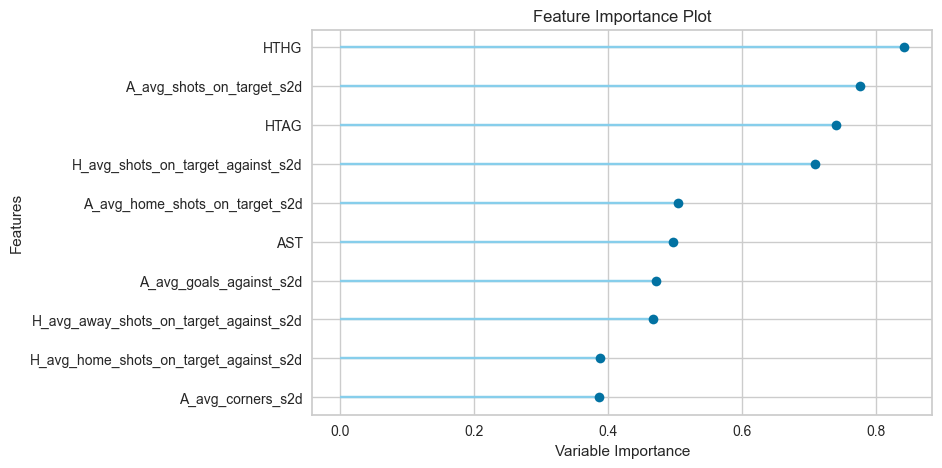

In [33]:
plot_model(best, plot = 'feature')